# Visualize taxa across shotgun sequencing samples

In [2]:
# Libraries
library(tidyverse)
library(reshape2)
library(ComplexHeatmap)
library(edgeR)
library(RColorBrewer)

# Extra
library(compositions)

*Load data and compute phylum ratio across samples*

In [ ]:
# Samples
s <- c('OP0.2A','OP0.2B','OP0.2C','OP1.2A','OP1.2B','OP1.2C','OP5.0A','OP5.0B','OP5.0C','OP8.0A','OP8.0B','OP8.0C', 'EN0.2A','EN0.2B','EN0.2C')

# Data
df <- read.delim("counts.lca.rarefy.tsv")

# Phylum
dfeu <- df %>% filter(superkingdom == "Eukaryota")
ph <- dfeu %>% group_by(phylum) %>% drop_na("phylum") %>% select(s) %>% melt() %>% ungroup() %>%
group_by(phylum, variable) %>% summarise(value = sum(value)) %>%
spread(phylum, value) %>% rename(sample = variable) %>% as.data.frame()
rownames(ph) <- ph$sample
ph <- ph %>% select(-sample) %>% t() %>% as.data.frame() %>% arrange(desc(OP0.2A))
write.table(ph, file='reads.lca.phylum.tsv', quote=FALSE, sep='\t', col.names=T ,row.names=F)

phperc <- apply(ph,2,function(x){round(x/sum(x)*100,2)})
write.table(phperc, file='reads.lca.perc.phylum.tsv', quote=FALSE, sep='\t', col.names=T ,row.names=F)

# Sort
labels <- (df[,c(1,2,3)] %>% filter(superkingdom == "Eukaryota") %>% unique() %>% select(kingdom, phylum))
labels <- merge(labels, rownames(ph), by.x="phylum", by.y="y") %>% arrange(kingdom)
labels$kingdom[is.na(labels$kingdom)] <- "Undefined"

# Color
lab <- colorRampPalette(c("lightblue","lightyellow","orange","red","darkred"),  space = "Lab")

*Compute CLR*

In [59]:
table <- clr(ph)
table <- table[labels$phylum,]
table <- table[,c(13:15,1:12)]

*Visualize CLR across shotgun samples: Eukaryotes only*

png 
  2

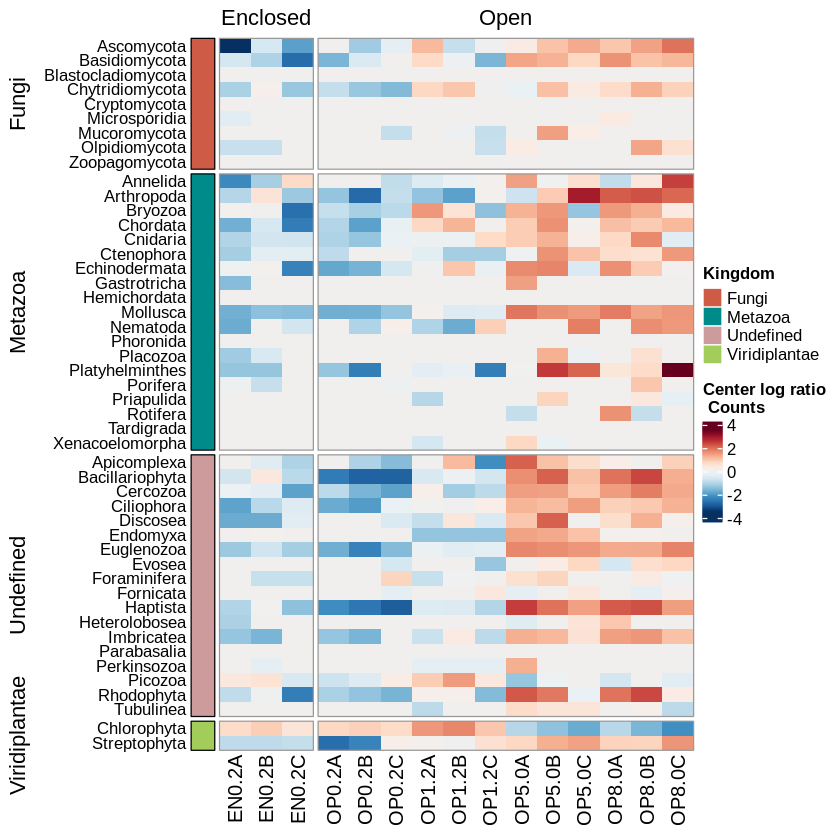

In [60]:
# Heatmap
colors = rev(colorRampPalette(brewer.pal(11,"RdBu"))(16))
annot <- rowAnnotation(Kingdom = labels$kingdom, show_annotation_name = F,
                       col = list(Kingdom = c("Fungi"="coral3", "Metazoa"="darkcyan", "Viridiplantae"="darkolivegreen3", "Undefined"="rosybrown3")), border = T)
p <- Heatmap(as.matrix(table), name = "Center log ratio \n Counts", cluster_rows = F, cluster_columns = F,
             row_order = labels$phylum, col = colors, left_annotation = annot, row_split = labels$kingdom,
             row_names_side = "left", row_names_gp = gpar(fontsize = 10), border = "gray60",
             column_split = c(rep("Enclosed",3), rep("Open",12)), raster_quality=3)
draw(p)

png(file="07-Plots/Heatmap.EU.CLR.png", width=2300, height=2000, res=300)
draw(p)
dev.off()

*Visualize the effect of CLR transformation on taxa read counts*

In [49]:
# CLR effect on data
ph_melt <- melt(ph)
clr_melt <- melt(as.data.frame(table))

No id variables; using all as measure variables

No id variables; using all as measure variables



In [56]:
p <- ph_melt %>% ggplot() + geom_histogram(aes(x=value, fill=variable), bins=50) +
facet_wrap(~variable)
png(file="07-Plots/eDNA_preCLR.png", width=2300, height=2000, res=300)
p
dev.off()

png 
  2

In [57]:
p <- clr_melt %>% ggplot() + geom_histogram(aes(x=value, fill=variable), bins=50) +
facet_wrap(~variable)
png(file="07-Plots/eDNA_postCLR.png", width=2300, height=2000, res=300)
p
dev.off()

png 
  2

*Visualize CLR across shotgun samples: All kingdoms*

In [61]:
# All phyla

ph <- df %>% group_by(phylum) %>% drop_na("phylum") %>% select(s) %>% melt() %>% ungroup() %>%
group_by(phylum, variable) %>% summarise(value = sum(value)) %>% spread(phylum, value) %>%
rename(sample = variable) %>% as.data.frame()
rownames(ph) <- ph$sample
ph <- ph %>% select(-sample) %>% t() %>% as.data.frame() %>% arrange(desc(OP0.2A))

labels <- (df[,c(1,2,3)] %>% unique() %>% select(superkingdom, phylum))
labels <- merge(labels, rownames(ph), by.x="phylum", by.y="y") %>% arrange(superkingdom)

table <- clr(ph)
table <- table[labels$phylum,]
table <- table[,c(13:15,1:12)]

Adding missing grouping variables: `phylum`
Using phylum as id variables

`summarise()` has grouped output by 'phylum'. You can override using the `.groups`
argument.


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

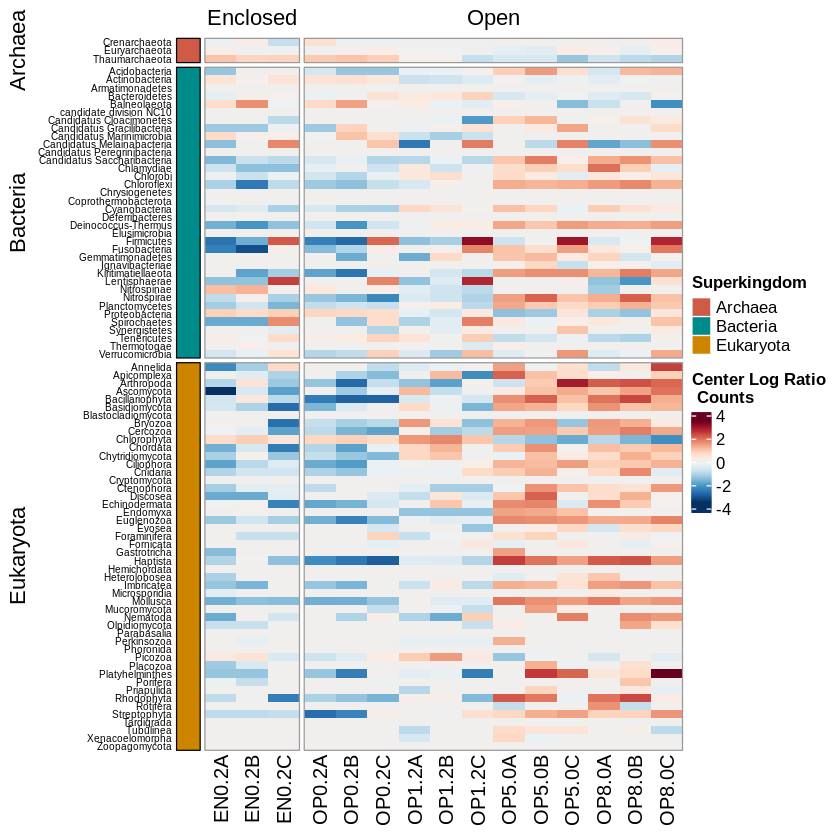

In [62]:
colors = rev(colorRampPalette(brewer.pal(11,"RdBu"))(16))
annot <- rowAnnotation(Superkingdom = labels$superkingdom, show_annotation_name = F, col = list(Superkingdom = c("Archaea"="coral3", "Bacteria"="darkcyan", "Eukaryota"="orange3", "Viruses"="darkolivegreen3")), border = T)
p <- Heatmap(as.matrix(table), name = "Center Log Ratio \n Counts", cluster_rows = F, cluster_columns = F,
             row_order = labels$phylum, col = colors, left_annotation = annot, row_split = labels$superkingdom,
             row_names_side = "left", row_names_gp = gpar(fontsize = 6), border = "gray60",
             column_split = c(rep("Enclosed",3), rep("Open",12)), use_raster=T, raster_quality=5)
draw(p)

png(file="07-Plots/Heatmap.ALL.CLR.png", width=2300, height=2000, res=300)
draw(p)
dev.off()

*Inspect data at the kingdom level*

In [ ]:
# -----------------------------
### Summary tables

# Top5 Bacteria
bac <- labels %>% filter(superkingdom == "Bacteria")
ph_bac <- ph[bac$phylum,]
ph_bac %>% arrange(desc(A0_2)) %>% head(5)

## Number of unique taxa per taxonomic level and pore size
df$p02 <- rowSums(df[,c(9:11)])
df$p12 <- rowSums(df[,c(12:14)])
df$p50 <- rowSums(df[,c(15:17)])
df$p80 <- rowSums(df[,c(18:20)])
df$pGP <- rowSums(df[,c(21:23)])

numTaxa <- function(df, taxlevel, col) {
  for (domain in c("Archaea","Bacteria","Eukaryota","Viruses")) {
    tmp <- (df %>% filter(superkingdom == sym(domain)) %>% select(taxlevel,col) %>% group_by(UQ(sym(taxlevel))) %>% summarise(tmp = sum(UQ(sym(col)))) %>% drop_na() %>% filter(tmp > 0) %>% dim())[1]
    message(paste(domain, taxlevel, col, ":", tmp))
  }
}

# Phylum
numTaxa(df, "phylum", "pGP")
numTaxa(df, "phylum", "p02")
numTaxa(df, "phylum", "p12")
numTaxa(df, "phylum", "p50")
numTaxa(df, "phylum", "p80")

# Class
numTaxa(df, "class", "pGP")
numTaxa(df, "class", "p02")
numTaxa(df, "class", "p12")
numTaxa(df, "class", "p50")
numTaxa(df, "class", "p80")

# Order
numTaxa(df, "order", "pGP")
numTaxa(df, "order", "p02")
numTaxa(df, "order", "p12")
numTaxa(df, "order", "p50")
numTaxa(df, "order", "p80")

# Family
numTaxa(df, "family", "pGP")
numTaxa(df, "family", "p02")
numTaxa(df, "family", "p12")
numTaxa(df, "family", "p50")
numTaxa(df, "family", "p80")

# Genus
numTaxa(df, "genus", "pGP")
numTaxa(df, "genus", "p02")
numTaxa(df, "genus", "p12")
numTaxa(df, "genus", "p50")
numTaxa(df, "genus", "p80")

# Species
numTaxa(df, "species", "pGP")
numTaxa(df, "species", "p02")
numTaxa(df, "species", "p12")
numTaxa(df, "species", "p50")
numTaxa(df, "species", "p80")

## Top5 phyla per pore size

df2 <- df[,c(1,3,9:23)]

df3 <- df2 %>% filter(superkingdom == "Eukaryota") %>% select(-superkingdom) %>% group_by(phylum) %>% summarise_at(s, sum) %>% drop_na(phylum) %>% arrange(desc(A0_2))

# 0.2
df3 %>% select(phylum,s[1:3]) %>% head(5)

# Plot
df3_plot <- df3 %>% melt()
df3_plot$variable <- factor(df3_plot$variable, levels = c('GP_1','GP_2','GP_3','A0_2','B0_2','C0_2','A1_2','B1_2','C1_2','A5_0','B5_0','C5_0','A8_0','B8_0','C8_0'))
df3_plot %>% ggplot() + geom_point(aes(x=variable, y=log(value), color=phylum)) + facet_wrap(~phylum) + guides(color = "none") + theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90))
